In [1]:
import numpy as np
import torch
import torchvision.models as models
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import to_2tuple,to_3tuple,DropPath,Mlp
from torchvision import transforms,datasets
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.ops import Conv2dNormActivation
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import seaborn as sns
from operator import truediv
import pandas as pd
from PIL import Image
from torchcam.methods import SmoothGradCAMpp,CAM

In [2]:
class hetconv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.c1 = self.c = Conv2dNormActivation(in_channels,16,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.c2 = self.c = Conv2dNormActivation(16,out_channels,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        x = self.c1(x)
        x = self.pool1(x)
        x = self.c2(x)
        x = self.pool1(x)
        return x

### Patch Embeddings

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self,image_size=56,patch_size=7,in_chans=1,embed_dim=56):
        super().__init__()
        image_size = to_2tuple(image_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans,embed_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self,x):
        B,C,H,W = x.shape

        x = self.proj(x).flatten(2).transpose(1,2)
        return x

### MLP Block

In [4]:
class MLP(nn.Module):
    def __init__(self,in_features,hidden_features=None,out_features=None,act_layer=nn.GELU,drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features,hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features,out_features)
        self.drop = nn.Dropout(drop)

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Attention Layer

In [5]:
class Attention(nn.Module):
    def __init__(self,dim,num_heads=8,qkv_bias=False,qk_scale=None,attn_drop=0.,proj_drop=0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self,x):
        B,N,C = x.shape
        qkv = self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[0], qkv[2]

        attn = (q @ k.transpose(-2,-1))*self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

### Block

In [6]:
class Block(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio = 4, qkv_bias=False,qk_scale=None,drop=0.,attn_drop=0.,drop_path = 0.,act_layer=nn.GELU,norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,num_heads=num_heads,qkv_bias=qkv_bias,qk_scale=qk_scale,attn_drop=attn_drop,proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2= norm_layer(dim)
        mlp_hidden_dim = int(dim*mlp_ratio)
        self.mlp = Mlp(in_features=dim,hidden_features=mlp_hidden_dim,out_features=dim,act_layer=act_layer,drop=drop)

    def forward(self,x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

### Vision Transformer

In [7]:
class VTransformer(nn.Module):
    def __init__(self, img_size=56, patch_size=7, in_chans=3, num_classes=2, embed_dim=56, depth=8,num_heads=8, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Sequential(
            hetconv(in_chans,32)
        )
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(image_size=img_size, patch_size=patch_size, in_chans=32, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer) for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()


    def forward_features(self,x):
        x = self.conv(x)
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:,0]
    
    def forward(self,x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [8]:
img = torch.ones([1, 3, 224, 224])
    
model = VTransformer()

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

out = model(img)
print("Shape of out :", out.shape)

Trainable Parameters: 0.402M
Shape of out : torch.Size([1, 2])


### Training

In [8]:
torch.manual_seed(0)
np.random.seed(0)

In [9]:
mean, std = (0.1,), (0.1,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])

In [10]:
train_data = datasets.ImageFolder('train',transform=transform)
valid_data = datasets.ImageFolder('test',transform=transform)

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=40, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
model = VTransformer().to(device)

In [14]:
model

VTransformer(
  (conv): Sequential(
    (0): hetconv(
      (c1): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (c): Conv2dNormActivation(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (c2): Conv2dNormActivation(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padd

In [16]:
i = 0
for img, label in trainloader:
    img = img.to(device)
    label = label.to(device)
    
    
    print("Input Image Dimensions: {}".format(img.size()))
    print("Label Dimensions: {}".format(label.size()))
    print("-"*100)
    
    out = model(img)
    print("Output Dimensions: {}".format(out.size()))
    print(out[21])
    break

Input Image Dimensions: torch.Size([32, 3, 224, 224])
Label Dimensions: torch.Size([32])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([32, 2])
tensor([0.4568, 0.6752], device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
model.load_state_dict(torch.load('model/ViT.pth'))

<All keys matched successfully>

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
expr_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [3, 7], gamma=0.1)

In [55]:
loss_list = []
accuracy_list = []
iteration_list = []

def train(epoch):
    expr_lr_scheduler.step()
    i = 0
    for features, labels in tqdm(trainloader):
        features, labels = Variable(features).to(device), Variable(labels).to(device)

        # zero out gradients from previous iteration
        optimizer.zero_grad()

        # forward propagation
        output = model(features)
        # calculate loss
        loss = criterion(output, labels)

        # backprop
        loss.backward()
        
        # update params (gradient descent)
        optimizer.step()
            
        i += 1

In [56]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for features, labels in tqdm(data_loader):
        with torch.no_grad():
            features, labels = Variable(features).to(device), Variable(labels).to(device)
            output = model(features)
            
        loss += F.cross_entropy(output, labels, size_average=False).data.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    print('Epoch: {}, Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
        epoch,
        loss, correct, len(data_loader.dataset),
        accuracy))
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    iteration_list.append(epoch)

In [57]:
n_epochs = 20

for epoch in range(n_epochs):
    train(epoch)
    evaluate(validloader)

c:\Users\anike\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [18]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, 15+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
          
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 13.05858970
       Train Accuracy%:  91.34615384615384 == 2375 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 13.64694096
       Train Accuracy%:  91.0 == 2366 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 11.61774646
       Train Accuracy%:  92.26923076923077 == 2399 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 12.14999632
       Train Accuracy%:  92.6923076923077 == 2410 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 9.98530429
       Train Accuracy%:  94.26923076923077 == 2451 / 2600
-------------------------------------------------
-----------------------------------

In [20]:
torch.save(model.state_dict(),'model/ViT.pth')

In [20]:
import matplotlib.pyplot as plt

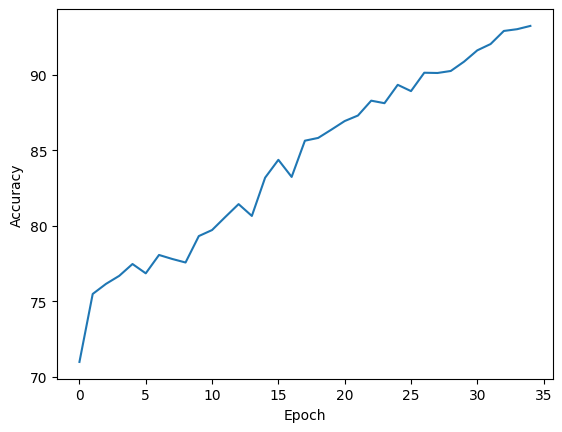

In [20]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [16]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(validloader):
        img = img.to(device)
        label = labels.to(device)
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  84.0909090909091 == 555 / 660


In [18]:
def get_confusion_matrix(y_test,y_pred, plt_name):

    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

    df_cm.columns = ['benign','malignant']

    df_cm = df_cm.rename({0:'benign',1:'malignant'})
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    sns.set(font_scale=0.9)

    sns.heatmap(df_cm, cmap="Blues",annot=True,annot_kws={"size": 16}, fmt='g')

    plt.savefig('cmetrics/'+str(plt_name)+'.eps', format='eps')

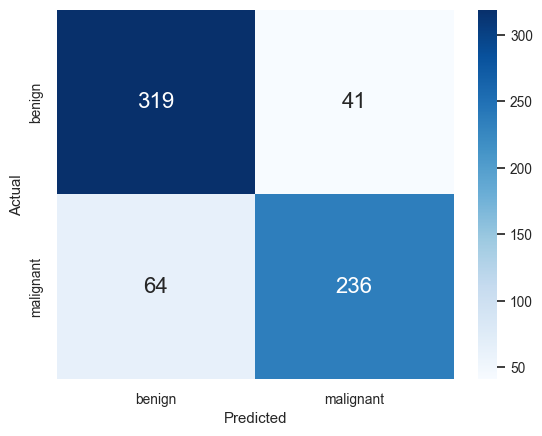

In [21]:
get_confusion_matrix(y_true_test,y_pred_test,'ViT')

In [22]:
cm = confusion_matrix(y_pred_test,y_true_test)

In [23]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]

    list_diag = np.diag(confusion_matrix)

    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))

    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [24]:
each_class,avg = AA_andEachClassAccuracy(cm)

In [25]:
each_class

array([0.83289817, 0.85198556])

In [26]:
avg

0.8424418659452735

In [27]:
from sklearn.manifold import TSNE

In [29]:
def gen_features():
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(trainloader)):
                print(idx+1, '/', len(trainloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

In [30]:
target,output = gen_features()

10 / 65
20 / 65
30 / 65
40 / 65
50 / 65
60 / 65
65 / 65


In [31]:
import os
import matplotlib.pyplot as plt

In [32]:
def tsne_plot(save_dir, targets, outputs):
    print('generating t-SNE plot...')
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.dark_palette("green",n_colors=2),
        #palette=sns.color_palette("hls", 5),
        data=df,
        s=400,
        #markers={"all":'o',"hem":'o'},
        #style='targets',
        legend=False,
        alpha=1
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.savefig(os.path.join(save_dir,'tsne_ViT.eps'), bbox_inches='tight')
    print('done!')


generating t-SNE plot...
done!


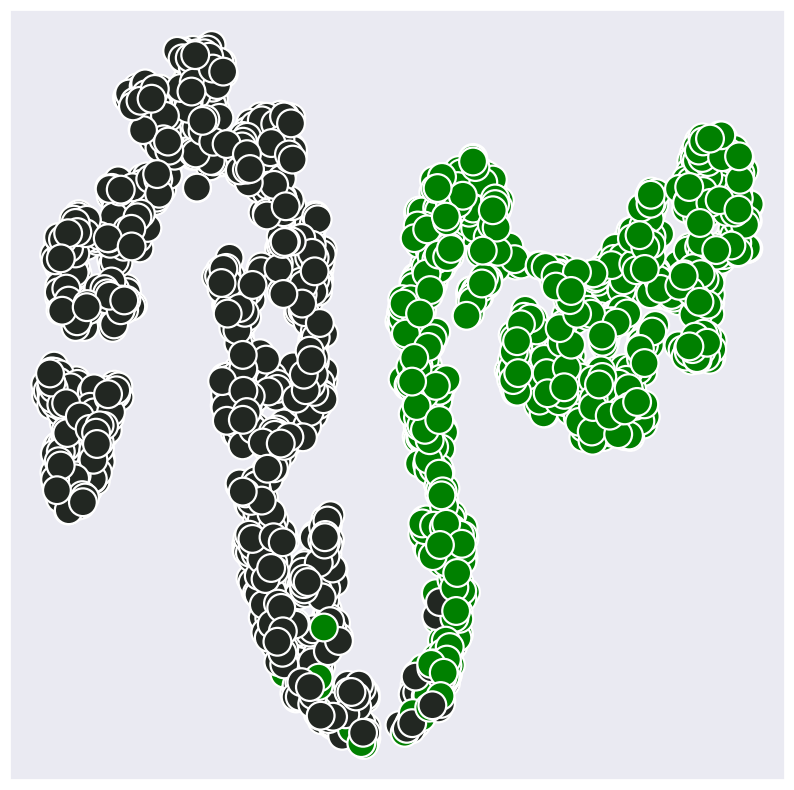

In [33]:
tsne_plot('tsne', target, output)

In [16]:
img = Image.open("data/training_data/augmented_data_fold_1/train/all/dr_1_1110.bmp")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])
img = transform(img)
img = img.unsqueeze(0)
img = img.to(device)

In [23]:
cam_extractor = SmoothGradCAMpp(model,'conv')

In [24]:
out = model(img)

In [25]:
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

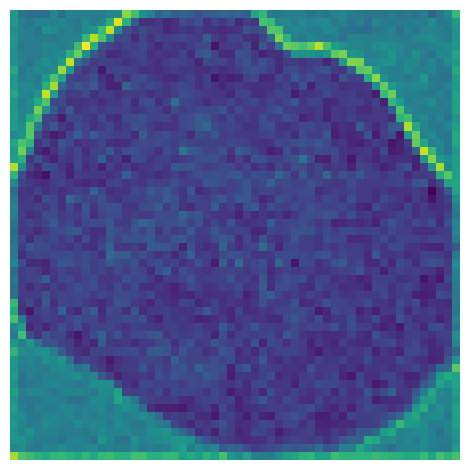

In [26]:
import matplotlib.pyplot as plt

plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

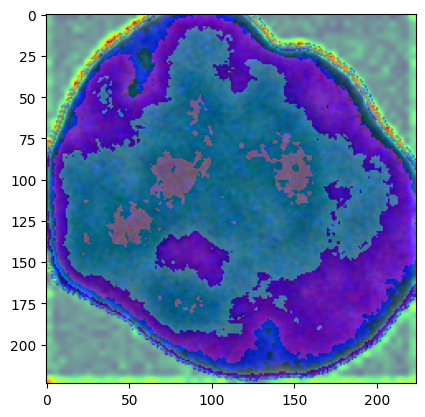

In [27]:
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

result = overlay_mask(to_pil_image(img[0]), to_pil_image(activation_map[0].cpu().squeeze(0), mode='F'), alpha=0.5)
plt.imshow(result)